# Partial Report: Extracting Forest Areas from Google Maps Aerial Images

This partial report documents first explorations in achieving the project objective of extracting forest area from Google Maps aerial images. 

I begin by examining three sample images from my dataset. The following three images are selected because they have are very different in the features of interest. They will provide a good basis for testing segmentation and classification approaches. 
- Image 1 is mostly covered by trees. It provides a good base sample for different shades of forest green. I will use this image to set up my approach, while the other two images will help challenge the segmentation and classification algorithms. 
- Image 2 has smaller sections of forest cover among a diverse landscape of green and brown agricultural fields and roads. The forest areas in this image are diverse in green color, shape, and size. For example, there is a thin forest region following the shape of a river crossing the top left region of the image, a dark, dense region of forest in between some agricultural fields in the middle of the image, and another forest region at the top right that thins out and ‘bleeds’ into surrounding fields. This will test different aspects of my segmentation and classification methods.
- Image 3 has very few forest areas, but it shows a large body of water in the top left corner (Tietê River). It will be difficult to distinguish this river from the forest areas, because it has virtually the same color. 

The three images are displayed below:

Text(0.5, 1.0, 'Image 3')

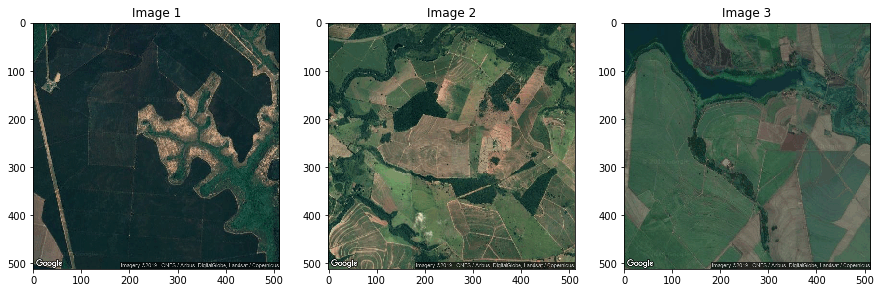

In [13]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import matplotlib
from scipy.fftpack import fftn, ifftn

# read sample images in rgb
img = imageio.imread('images/lat-21.553191851763607_long -47.58674520014182_map.png')
img2 = imageio.imread('images/lat-22.284617723129536_long -48.18559920332148_map.png')
img3 = imageio.imread('images/lat-22.200495034324955_long -48.69176482972345_map.png')

# plot images
plt.figure(figsize=(15,10))
plt.subplot(131); plt.imshow(img); plt.title("Image 1")
plt.subplot(132); plt.imshow(img2); plt.title("Image 2")
plt.subplot(133); plt.imshow(img3); plt.title("Image 3")


Differentiating between rivers and forest areas is an example of a challenge that may arise in this classification task. The two plots below show 50x50 pixel subsets of images 1 and 3 respectively. The left shows a tree-covered area, while the right shows the river. For the viewer, the two plots have nearly the same color. Identifying forest areas will depend on texture, not just color.

Text(0.5, 1.0, 'River')

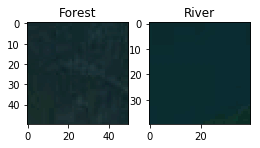

In [14]:
plt.figure(figsize=(4,2))
plt.subplot(121); plt.imshow(img[160:210,60:110]); plt.title('Forest')
plt.subplot(122); plt.imshow(img3[10:50,10:50]); plt.title('River')

As a preprocessing step, I remove the bottom pixel rows containing the google logo, because these black and white pixels are much darker/brighter than the rest of the image. Removing them expands the available range for the different color channels and makes it easier to segment the different regions.

In [15]:
# preprocessing step: crop google logo region
img = img[0:490,:]
img2 = img2[0:490,:]
img3 = img3[0:490,:]

Color will be a key identifying feature of forest areas, so I begin by examining the different color channels using both the RGB and the HSV color scheme. For example, below are the color channels and corresponding histograms for Image 1:

Text(0.5, 1.0, 'Value')

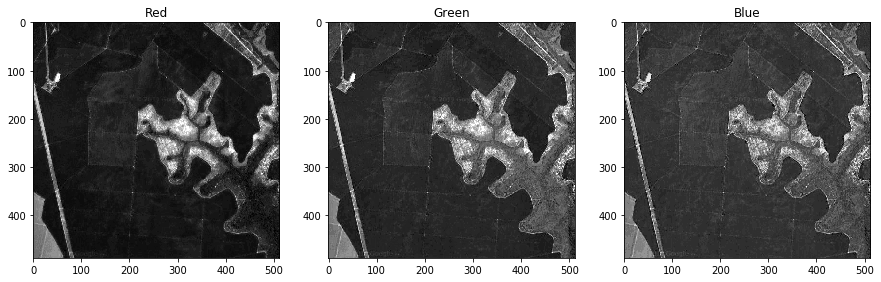

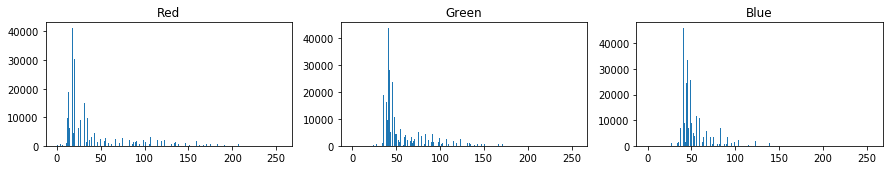

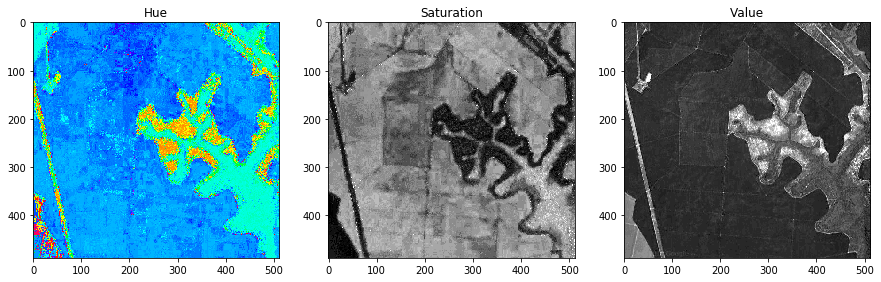

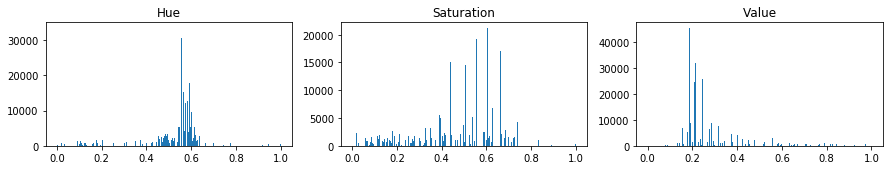

In [16]:
# separate the RGB channels
Red = img[:,:,0].astype('float')
Green = img[:,:,1].astype('float')
Blue = img[:,:,2].astype('float')
# normalize to range 0-1
Rnorm = (Red - Red.min())/(Red.max() - Red.min())
Gnorm = (Green - Green.min())/(Green.max() - Green.min())
Bnorm = (Blue - Blue.min())/(Blue.max() - Blue.min())

# plot each R, G, B seperately
plt.figure(figsize=(15,10))
plt.subplot(231); plt.imshow(Red, cmap="gray"); plt.title("Red")
plt.subplot(232); plt.imshow(Green, cmap="gray"); plt.title("Green")
plt.subplot(233); plt.imshow(Blue, cmap="gray"); plt.title("Blue")
## Histograms
plt.figure(figsize=(15,5))
plt.subplot(234); plt.hist(Red.ravel(), bins=256, range=(0,255)); plt.title('Red')
plt.subplot(235); plt.hist(Green.ravel(), bins=256, range=(0,255)); plt.title('Green')
plt.subplot(236); plt.hist(Blue.ravel(), bins=256, range=(0,255)); plt.title('Blue')


# convert to hsv
img_hsv = matplotlib.colors.rgb_to_hsv(np.dstack((Rnorm, Gnorm, Bnorm)))

plt.figure(figsize=(15,10))
plt.subplot(231); plt.imshow(img_hsv[:,:,0], cmap="hsv"); plt.title("Hue");
plt.subplot(232); plt.imshow(img_hsv[:,:,1], cmap="gray"); plt.title("Saturation")
plt.subplot(233); plt.imshow(img_hsv[:,:,2], cmap="gray"); plt.title("Value")
## Histograms
plt.figure(figsize=(15,5))
plt.subplot(234); plt.hist(img_hsv[:,:,0].ravel(), bins=256, range=(0,1)); plt.title('Hue')
plt.subplot(235); plt.hist(img_hsv[:,:,1].ravel(), bins=256, range=(0,1)); plt.title('Saturation')
plt.subplot(236); plt.hist(img_hsv[:,:,2].ravel(), bins=256, range=(0,1)); plt.title('Value')

Most of the pixels in the above image represent forest cover. This means that spikes in the color channels can help identify ranges of both R,G,B and H,S,V that correspond to the forest green tones. The next section uses this information for a first segmentation into forest and non-forest areas.


## Threshold segmentation using color
As a simple baseline, an examination of the histograms gives the following ranges for segmentation:
* RGB (range from 0-255): 
    * Red: 0 - 45 
    * Green: 30 - 55 
    * Blue: 30 - 50
    
* HSV (range from 0-1):
    * Hue: 0.5-0.6
    * Saturation: all levels
    * Value: 0 - 0.30

I use these ranges to define a simple threshold segmentation based on color. Below are the results for both color systems.
### 1. RGB

Text(0.5, 1.0, 'RGB Segmentation')

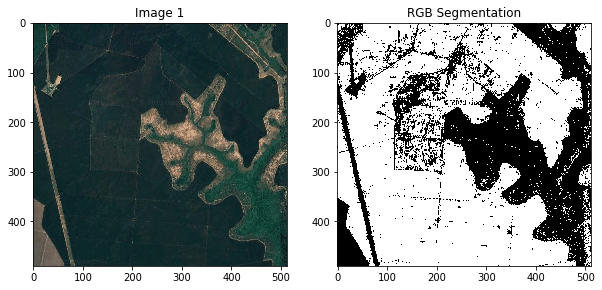

In [17]:
## RGB thresholding (histograms above)
# R<45, 30<G<55, 30<B<50
img_rgb_trees = np.where((Red<45) &
                         (Green>30) & (Green<55)
                         & (Blue>30) & (Blue<50),
                         1,0)
plt.figure(figsize=(10,5))
plt.subplot(121); plt.imshow(img); plt.title('Image 1')
plt.subplot(122);plt.imshow(img_rgb_trees, cmap='gray'); plt.title('RGB Segmentation')


In this and other segmentations, the following holds:

**White pixels = forest cover**

**Black areas = other**

This segmentation correctly identifies most non-forest areas though there are some spurious false negative results (white dots). Similarly, most tree-covered areas are correctly classified, though some lighter forest regions are misclassified and/or very noisy.

### 2. HSV

Text(0.5, 1.0, 'HSV Segmentation')

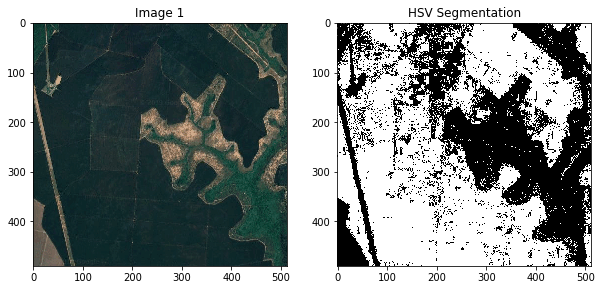

In [18]:
## HSV thresholding (histograms above)
# 0.45<H<0.55, S?, 0.1<V<0.2
img_hsv_trees = np.where((img_hsv[:,:,0]<0.6) & (img_hsv[:,:,0]>0.5) & 
                         (img_hsv[:,:,2]<0.3), 
                         1,0)
plt.figure(figsize=(10,5))
plt.subplot(121); plt.imshow(img); plt.title('Image 1')
plt.subplot(122);plt.imshow(img_hsv_trees, cmap='gray'); plt.title('HSV Segmentation')

As with RGB, most forest and non-forest regions are identified correctly, though there is more misclassification of the lighter forest areas, e.g. in the top center of the image. Further tuning of the thresholds can improve performance, but at the risk of overfitting. How do the threshold segmentations perform on the other two images?

### 3. RGB and HSV Segmentation on Test Images

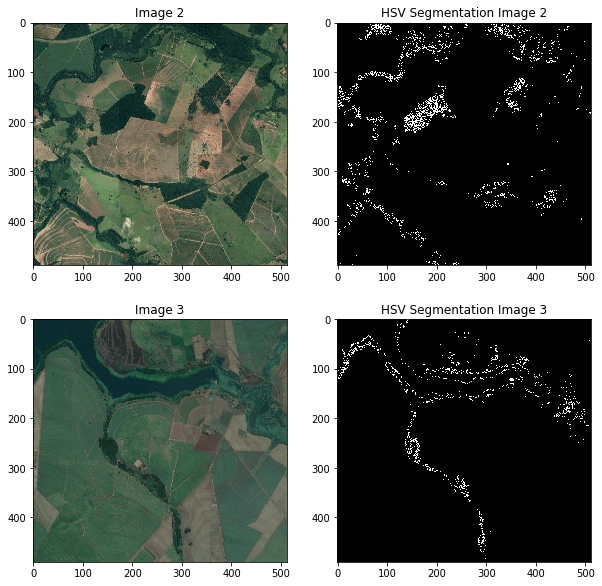

In [19]:
# utility function to normalize RGB before segmentation
def RGB_normalizer(img):
    '''
    Takes as input an RGB image and normalizes each channel to range 0-1.
    Returns stacked array with three arrays of normalized R, G, and B
    '''
    Red = img[:,:,0].astype('float')
    Green = img[:,:,1].astype('float')
    Blue = img[:,:,2].astype('float')
    # normalize to range 0-1
    Rnorm = (Red - Red.min())/(Red.max() - Red.min())
    Gnorm = (Green - Green.min())/(Green.max() - Green.min())
    Bnorm = (Blue - Blue.min())/(Blue.max() - Blue.min())
    
    img_out = np.dstack((Rnorm, Gnorm, Bnorm))
    
    return(img_out)


### HSV segmentation function
def HSV_seg(img, normalized = True):
    '''
    Segments image according to thresholds defined via histogram method
    Takes as input either RGB or normalized RGB.
    Returns binary matrix segmented into forest(1) and non-forest(0) areas.
    '''
    # normalize RGB channels if necessary:
    if normalized==False:
        img_norm = RGB_normalizer(img)
    elif normalized==True:
        img_norm = img.copy()
    # convert to HSV:    
    img_hsv = matplotlib.colors.rgb_to_hsv(img_norm)
    # apply threshold:
    img_hsv_trees = np.where((img_hsv[:,:,0]<0.6) & (img_hsv[:,:,0]>0.5) & 
                         (img_hsv[:,:,2]<0.3), 
                         1,0)
    return(img_hsv_trees)

## apply to images 2 and 3:
img2_hsv_trees = HSV_seg(img2, normalized = False)
img3_hsv_trees = HSV_seg(img3, normalized = False)

# plot results:
plt.figure(figsize=(10,10))
plt.subplot(221); plt.imshow(img2); plt.title("Image 2");
plt.subplot(222); plt.imshow(img2_hsv_trees, cmap = 'gray'); plt.title("HSV Segmentation Image 2");
plt.subplot(223); plt.imshow(img3); plt.title("Image 3");
plt.subplot(224); plt.imshow(img3_hsv_trees, cmap = 'gray'); plt.title("HSV Segmentation Image 3");

The forest areas in images 2 and 3 are more spurious and so are the HSV segmentation results. The general location of forest is visible, but there are many false negatives. At the same time, there appear to be few false positives. It is especially noteworthy that the HSV segmentation correctly identifies the river as non-forest area. 
Looking at the hue spectrum of image 3 confirms that hue (not just texture) will be an important feature to distinguish river and forest areas. The hue scale of image 3 below shows that the river and forest areas have different hues, showing up in light and dark blue below.

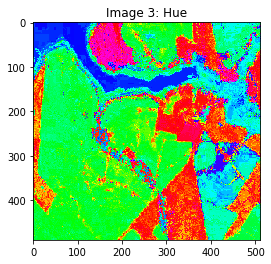

In [20]:
# normalize RGB channels
img3_norm = RGB_normalizer(img3)
# convert img3 from RGB to HSV
img3_hsv = matplotlib.colors.rgb_to_hsv(img3_norm)

plt.imshow(img3_hsv[:,:,0], cmap="hsv"); plt.title("Image 3: Hue");


## Vegetation Indices
Following the example in (Torres-Sanchez et al, 2014), I compute different vegetation indices to help classify forest areas.
* Color Index of Vegetation (CIVE)
$$CIVE = 0.441r - 0.881g + 0.385b + 18.78745$$

* Woebbecke Index
$$WI = \frac{g-b}{r-g}$$
* Excess Green (ExG)
$$ExG = 2g-r-b$$
* Excess Green minus Excess Red (ExGR)
$$ExGR = ExG-1.4r-g$$

These four indices are based on chromatic coordinates - linear combinations of the RGB color channels defined as follows:
$$r = \frac{R}{R+G+B}$$

$$g = \frac{G}{R+G+B}$$

$$b = \frac{R}{R+G+B}$$

Text(0.5, 1.0, 'Hist ExGR')

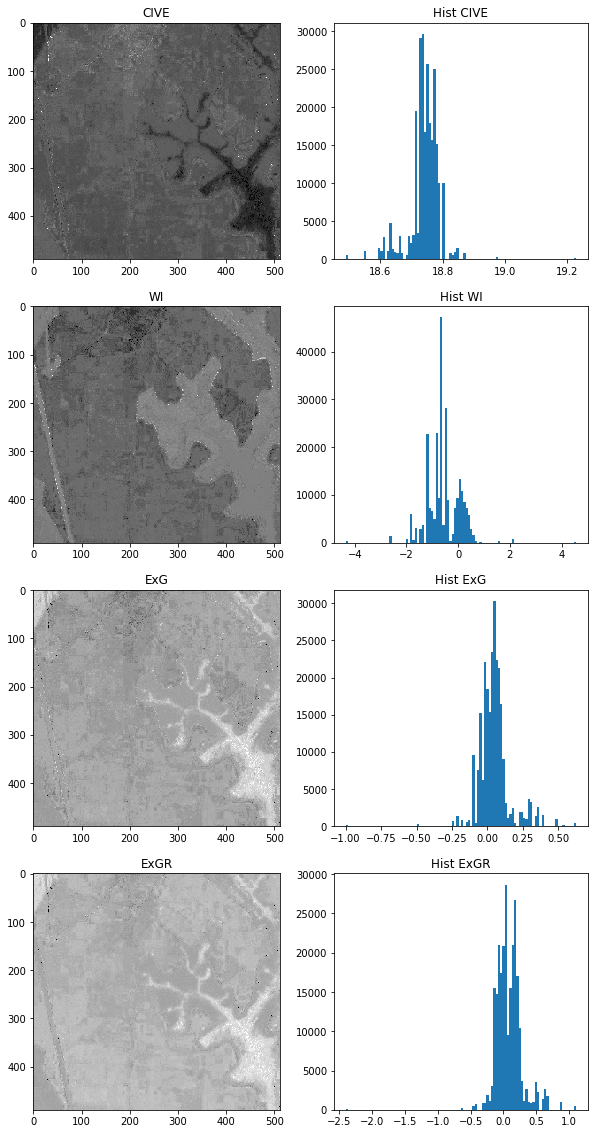

In [21]:
## Chromatic coordinates
r =  Rnorm / (Rnorm + Gnorm + Bnorm)
g = Gnorm / (Rnorm + Gnorm + Bnorm)
b = Bnorm / (Rnorm + Gnorm + Bnorm)


### CIVE (Color Index of Vegetation)
# CIVE =  0.441r - 0.881g + 0.385b + 18.78745
img_cive = 0.441*r - 0.881*g + 0.385*b + 18.78745
      
### ExG (Excess Green)
# ExG = 2g - r - b
img_exg = 2*g - r - b  

### ExG - ExR (Excess Green minus Excess Red)
# ExGR - ExG - 1.4r - g
img_exgr = img_exg - (1.4*r - g)

### Woebbecke index
# WI = (g - b) / |r - g|
# note: values -0.1<x<0.1 are set to 0.1
denom = abs(r - g)
denom = np.where(denom<0.1, 0.1, denom)
img_wi = (g - b) / denom


# plot the indices and their intensity histograms
plt.figure(figsize=(10,20))
# cive
plt.subplot(421); plt.imshow(img_cive, cmap = 'gray'); plt.title("CIVE");
plt.subplot(422); plt.hist(img_cive.ravel(), bins = 100); plt.title('Hist CIVE')
# wi
plt.subplot(423); plt.imshow(img_wi, cmap = 'gray'); plt.title("WI");
plt.subplot(424); plt.hist(img_wi.ravel(), bins = 100); plt.title('Hist WI')
# ExG
plt.subplot(425); plt.imshow(img_exg, cmap = 'gray'); plt.title("ExG");
plt.subplot(426); plt.hist(img_exg.ravel(), bins = 100); plt.title('Hist ExG')
# ExGR
plt.subplot(427); plt.imshow(img_exgr, cmap = 'gray'); plt.title("ExGR");
plt.subplot(428); plt.hist(img_exgr.ravel(), bins = 100); plt.title('Hist ExGR')

For image 1, the histogram of the Woebbecke index above clearly shows two separate distributions corresponding to the forest and non-forest areas. The CIVE and ExG indices group forest areas together with some grass areas. This means the indices alone cannot be used for segmentation (at least in this sample image), but they can still provide useful information if combined with other features of the image.

As with color channels above, I use the histograms to set thresholds for segmentation:

* WI: 0 - (-0.1)
* CIVE: 18.71 - 18.81
* ExG: -0.12 - 0.24
* ExGR: -0.1 - 0.1

This yields for example the following segmentation of image 1 using the Woebbecke Index:

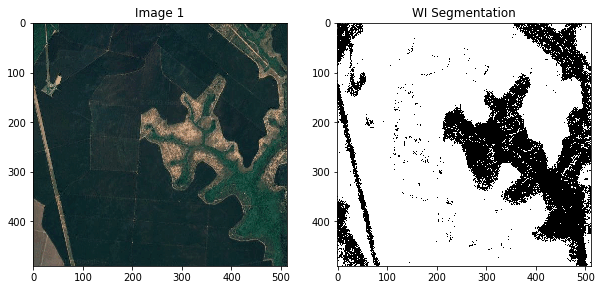

In [22]:
# WI Segmentation: trees<0.1
img_wi_trees1 = np.where((img_wi<(-0.1)),
                        1,0)
plt.figure(figsize=(10,5))
plt.subplot(121); plt.imshow(img); plt.title("Image 1");
plt.subplot(122); plt.imshow(img_wi_trees1, cmap='gray'); plt.title("WI Segmentation");


It appears to work fairly well for image 1. Can an optimization of the threshold improve segmentation results? I implement a simple algorithm from section 10.3.2 of (Gonzalez & Woods, 2006) to try and find a better threshold. The results are shown below:

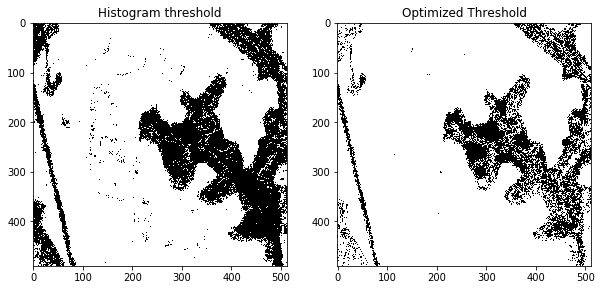

In [23]:
## Can we improve the threshold?
def threshold_finder(T0, img_in, delta_T):
    T_diff = delta_T+1
    while T_diff > delta_T:
        i1 = np.where(img_in<T0,
                      1,np.nan)*img_in
        i2 = np.where(img_in>T0,
                      1,np.nan)*img_in
        m1 = np.nanmean(i1)
        m2 = np.nanmean(i2)
        T = (1/2) * (m1 + m2)
        T_diff = abs(T0-T)
        T0=T
    return T0    

# find the threshold:    
T = threshold_finder(0.1, img_wi, 0.0001)    
# segment:
img_wi_trees2 = np.where((img_wi<0.1),
                        1,0)
# compare results:
plt.figure(figsize=(10,5))
plt.subplot(121); plt.imshow(img_wi_trees1, cmap = 'gray'); plt.title("Histogram threshold");
plt.subplot(122); plt.imshow(img_wi_trees2, cmap = 'gray'); plt.title("Optimized Threshold");

Based on the result, there are advantages to each of the thresholds. Segmenting with the threshold found from the histogram has fewer false positives, i.e. non-forest pixels incorrectly classified as forest pixels. Yet as a tradeoff, the segmentation missed several tree-covered pixels. Conversely, the optimized threshold effectively classifies nearly all forest areas but at the expense of adding many false positive pixels. Combining the optimized threshold WI segmentation with other features (e.g. by applying a multi-variable clustering approach) could help remedy the situation, as could post-segmentation filtering of spurious regions.

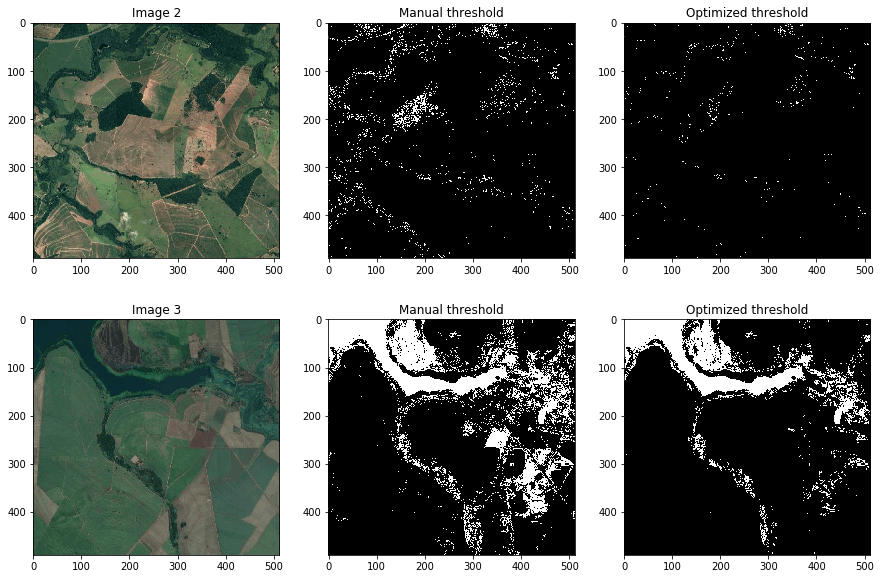

In [24]:
# helper function for chromatic coordinates
def chromatic_coords(img, normalized=True):
    '''
    Converts RGB to chromatic coordinates r, g, and b.
    Takes as input either raw RGB or normalized RGB image 
    and boolean normalization status.
    Returns 3d stacked array of r, g, and b.
    '''
    if normalized == False:
        img_norm = RGB_normalizer(img)
    elif normalized == True:
        img_norm = img.copy()
    # to avoid zero division
    img_norm = np.where(img_norm==0, 0.000001, img_norm)
    # separate the channels
    Rnorm = img_norm[:,:,0]
    Gnorm = img_norm[:,:,1]
    Bnorm = img_norm[:,:,2]
    # compute chromatic coords
    r =  Rnorm / (Rnorm + Gnorm + Bnorm)
    g = Gnorm / (Rnorm + Gnorm + Bnorm)
    b = Bnorm / (Rnorm + Gnorm + Bnorm)
    
    img_out = np.dstack((r, g, b))
    return(img_out)


# segmentation function using WI
def wi_seg(img, T, normalized=True):
    '''
    Segments according to Woebbecke index according to user-defined threshold.
    Takes as input either RGB or normalized RGB.
    Returns binary matrix segmented into forest(1) and non-forest(0) areas.
    '''
    # compute chromatic coordinates:
    chrom = chromatic_coords(img, normalized=normalized)
    
    ### compute Woebbecke index
    # WI = (g - b) / |r - g|
    # note: values -0.1<x<0.1 are set to 0.1
    denom = abs(chrom[:,:,0] - chrom[:,:,1])
    denom = np.where(denom<0.1, 0.1, denom)
    img_wi = (chrom[:,:,1] - chrom[:,:,2]) / denom
    
    ### segmentation
    img_wi_trees = np.where((img_wi<T),1,0)
    
    return img_wi_trees


### Segment images:
### Image 2 - histogram threshold:
img2_wi_trees1 = wi_seg(img2, T=-0.1, normalized=False)
# optimized threshold:
img2_wi_trees2 = wi_seg(img2, T=T, normalized=False)

### Image 3 - histogram threshold:
img3_wi_trees1 = wi_seg(img3, T=-0.1, normalized=False)
# optimized threshold:
img3_wi_trees2 = wi_seg(img3, T=T, normalized=False)

# plot results:
plt.figure(figsize=(15,10))
# Image 2
plt.subplot(231); plt.imshow(img2); plt.title("Image 2");
plt.subplot(232); plt.imshow(img2_wi_trees1, cmap = 'gray'); plt.title("Manual threshold");
plt.subplot(233); plt.imshow(img2_wi_trees2, cmap = 'gray'); plt.title("Optimized threshold");
# Image 3
plt.subplot(234); plt.imshow(img3); plt.title("Image 3");
plt.subplot(235); plt.imshow(img3_wi_trees1, cmap = 'gray'); plt.title("Manual threshold");
plt.subplot(236); plt.imshow(img3_wi_trees2, cmap = 'gray'); plt.title("Optimized threshold");


## Next Steps
* Trying more advanced segmentation techniques, e.g.:
    * clustering (using multiple color and vegetation features)
    * combinations of vegetation indices
* Filtering during pre-processing and/or after segmentation, in order to remove spurious regions and improve the final result
* Outline filtering of segmented image and combining outlines with original satellite images, e.g.:
    * high-pass filter
    * erosion filter
* Extracting information on image texture to aid classification
* Additional analysis of resulting output images, e.g.:
    * computing pixel share of segmented areas to estimate forest cover of total land area
    * adding geo-coded economic data, such as industry locations


## References

(1) Gonzalez, R. and Woods, R. (2008). Digital Image Processing. Upper Saddle River, NJ: Pearson Education.


(2) Kataoka, T., et al., (2003). Crop growth estimation system using machine vision. In: 2003 IEEE/ASME International Conference on Advanced Intelligent Mechatronics, 2003. AIM 2003. Proceedings. Presented at the 2003 IEEE/ASME International Conference on Advanced Intelligent Mechatronics, 2003. AIM 2003. Proceedings, pp. b1079–b1083, vol. 2.


(3) Torres-Sanchez, J. et al., (2014). Multi-temporal mapping of the vegetation fraction in early-season wheat fields using images from UAV. Computers and Electronics in Agriculture (103), 104–113.


(4) Woebbecke, D.M., Meyer, G.E., Von Bargen, K., Mortensen, D.A., 1995. Color indices for weed identification under various soil, residue, and lighting conditions. Trans. ASAE 38, 259–269.




